In [1]:
from pathlib import Path
from funman.api.run import Runner

# %load_ext autoreload
# %autoreload 2

In [7]:
# This cell will run FUNMAN on the scenario described by the `request_dict` and plot the points generated during the parameter space generatation.

# Setup Paths
RESOURCES = Path("../resources").resolve()
EXAMPLE_DIR = RESOURCES / "amr" / "petrinet" / "amr-examples"
MODEL_PATH = EXAMPLE_DIR / "sir.json"
REQUEST_PATH = EXAMPLE_DIR / "sir_request1.json"

request_dict = {
    # "query": {
    #     "variable": "I",
    #     "ub": 300
    # },
  "constraints": [
            {
                "name": "I_bounds_A",
                "variable": "I",
                "interval": {"lb": 0, "ub": 200},
                "timepoints": {"lb": 0, "ub": 40, "closed_upper_bound": True},
            },
            # {
            #     "name": "I_bounds_B",
            #     "variable": "I",
            #     "interval": {"lb": 10},
            #     "timepoints": {"lb": 40, "ub": 100, "closed_upper_bound": True},
            # },
  ],
  "parameters": [
   {
                "name": "beta",
                "interval": {"lb": 1e-8, "ub": 1e-2},
                "label": "all",
            },
            {
                "name": "gamma",
                "interval": {"lb": 0.1, "ub": 0.18},
                "label": "all",
            },
            {
                "name": "S0",
                "interval": {"lb": 1000, "ub": 1000},
                "label": "any",
            },
            {"name": "I0", "interval": {"lb": 1, "ub": 1}, "label": "any"},
            {"name": "R0", "interval": {"lb": 0, "ub": 0}, "label": "any"},
  ],
   "structure_parameters": [
        {
                "name": "schedules",
                "schedules": [
                    {
                        "timepoints": [
                            0,
                            # 5,
                            10,
                            # 15,
                            20,
                            30,
                            # 35,
                            40,
                            45,
                            50,
                            55,
                            60,
                            100,
                        ]
                    }
                ],
            }
    ],

    "config": {
            "normalization_constant": 1001,
            "tolerance": 1e-1,
            "use_compartmental_constraints" : True,
            # "profile": True
    }
}
    
# Use request_dict
results = Runner().run(MODEL_PATH, request_dict, description="Basic SIR with simple request", case_out_dir="./out")

# Use request file
# results = Runner().run(MODEL_PATH, REQUEST_PATH, description="Basic SIR with simple request", case_out_dir="./out")

results.plot(variables=["I"], label_marker={"true":",", "false": ","})

2023-10-24 21:19:33,350 - funman.server.worker - INFO - FunmanWorker running...
Interval([1000.0, 1000.0)) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
Interval([1.0, 1.0)) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
Interval([0.0, 0.0)) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2023-10-24 21:19:33,387 - funman.server.worker - INFO - Starting work on: ffa73880-4d1c-4911-9ffc-5b840939297f
Interval([1001.0, 1001.0)) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2023-10-24 21:19:34,072 - funman.search.box_search - INFO - Adding true point: Point({'type': 'point', 'label': 'unknown', 'values': {'beta': 0.005000005, 'gamma': 0.14000000000000004, 'S0': 1000.0, 'I0': 1.0, 'R0': 0.0, 'timer_t_0': 0.0, 'S_0': 1000.0, 'I_0': 1.0,

FunmanWorkerException: FunmanWorker be running to stop: WorkerState.STOPPED

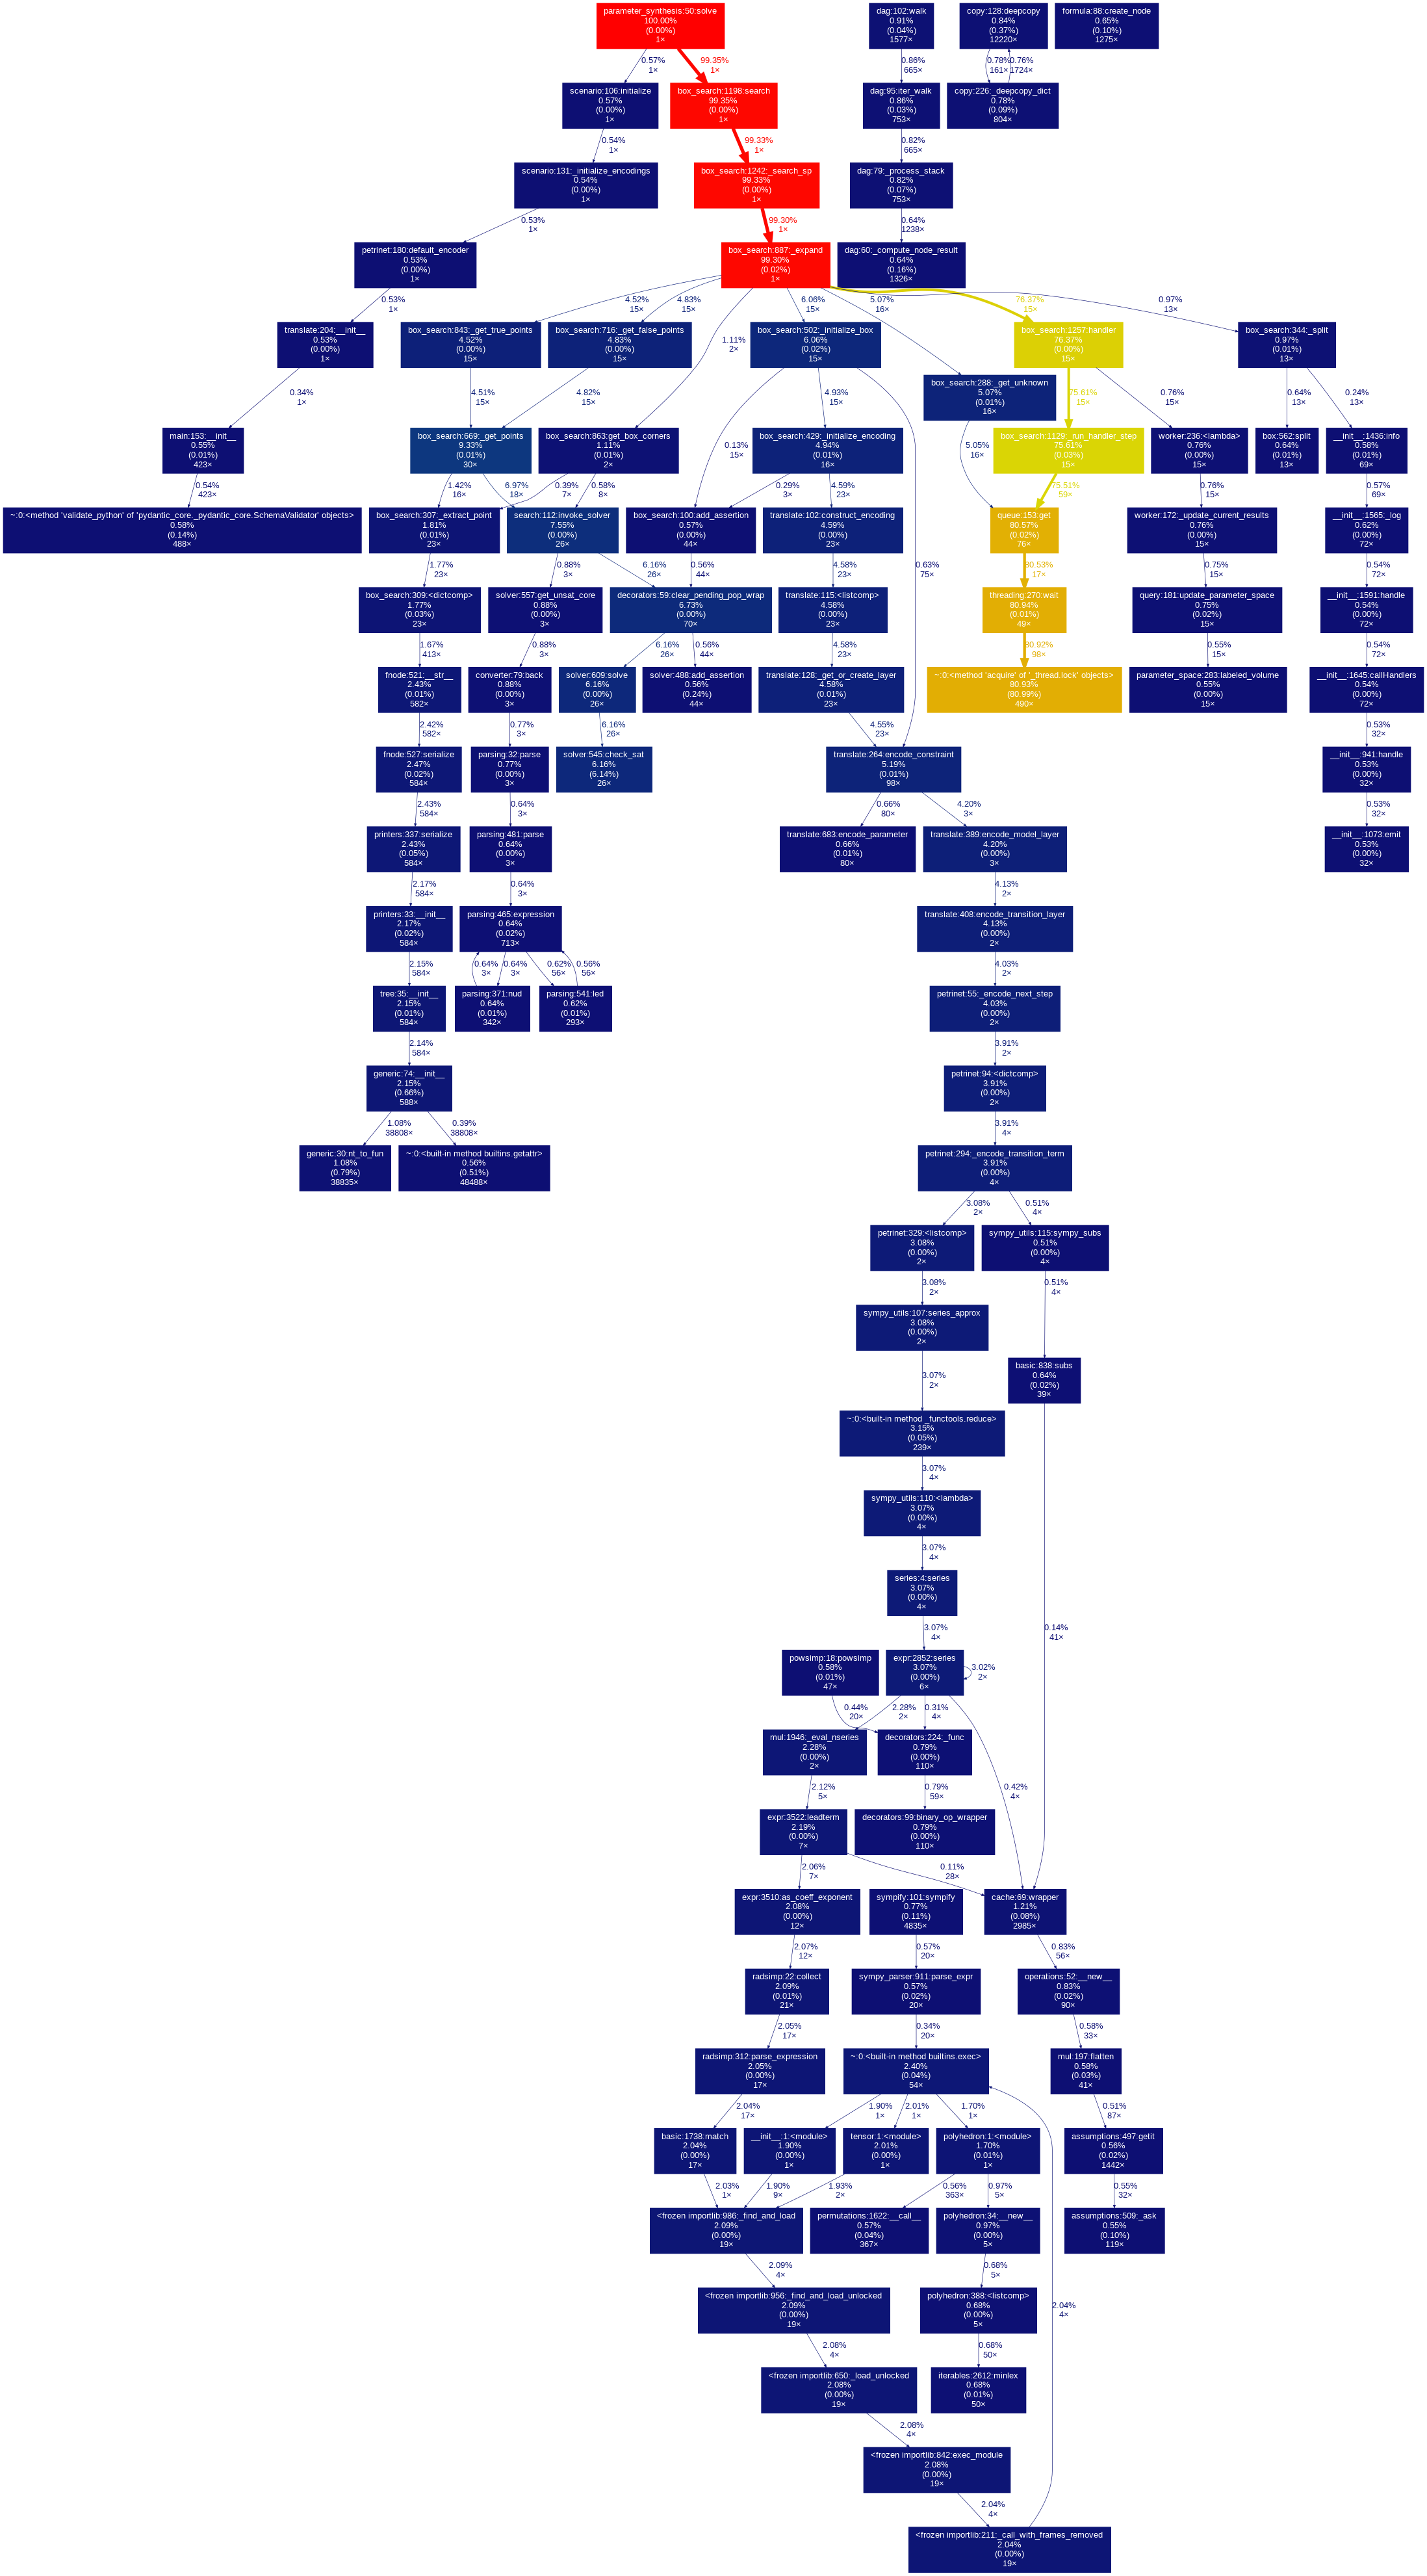

In [6]:
# View profiling if present (must set `"profiling": True` in the config above)

import os
from IPython.core.display import Image
from IPython.display import display
profile_file = os.path.join(f"./profile.stats")
if os.path.exists(profile_file):
    os.system(f"gprof2dot -f pstats {profile_file} | dot -Tpng -o profile.png")
    display(Image(filename='profile.png'))
else:
    print(f"{profile_file} file not present")

In [6]:
# Example uses the result object created by FUNMAN
# - Get the points and boxes
# - Get the parameters corresponding to a point
# - Generate a dataframe with the point timeseries

from funman import Point, Box, Parameter
from typing import List, Dict

points: List[Point] = results.points()
boxes: List[Box] = results.parameter_space.boxes()

print(
    f"{len(points)} Points (+:{len(results.parameter_space.true_points())}, -:{len(results.parameter_space.false_points())}), {len(boxes)} Boxes (+:{len(results.parameter_space.true_boxes)}, -:{len(results.parameter_space.false_boxes)})"
)
if points and len(points) > 0:
    point: Point = points[-1]
    parameters: Dict[Parameter, float] = results.point_parameters(point)
    print(parameters)
    print(results.dataframe([point]))
else:
    # if there are no points, then we have a box that we found without needing points

    box = boxes[0]
    print(json.dumps(box.explain(), indent=4))

0 Points (+:0, -:0), 0 Boxes (+:0, -:0)


IndexError: list index out of range

In [ ]:
# Get the corner points of a box

results.parameter_space.false_boxes[0].corner_points

In [ ]:
# Get the state varibles and parameters from a point (used by the dataframe timeseries function above)

results.parameter_space.true_points[0].values

In [ ]:
# Plot the parameter space

from funman_demo.parameter_space_plotter import ParameterSpacePlotter
ParameterSpacePlotter(
        results.parameter_space, plot_points=True, parameters=["beta", "gamma", "timestep"]
    ).plot(show=False)

KeyError: 'label'

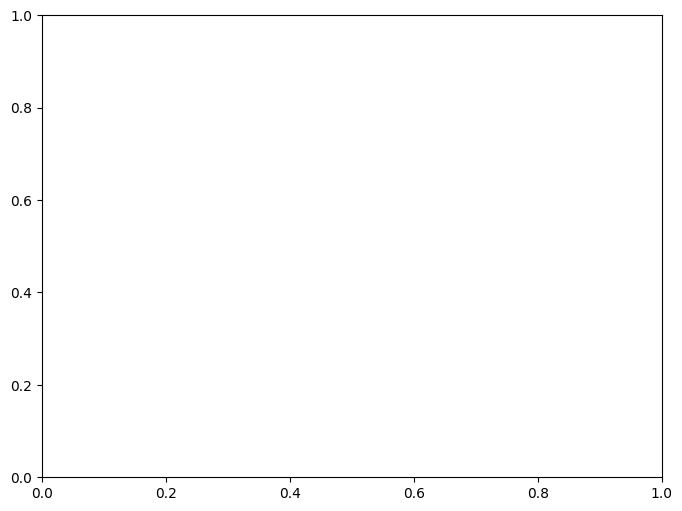

In [4]:
# Plot the timeseries for each point in the parameter space for the selected variables

results.plot(variables=["I"], label_marker={"true":",", "false": ","})

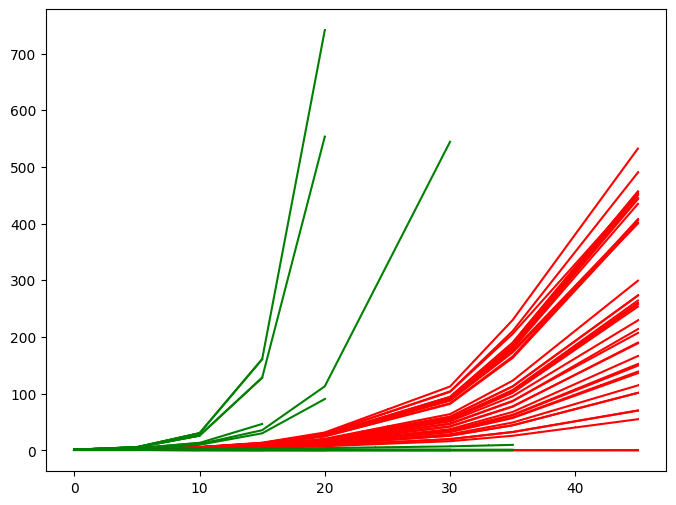

In [7]:
# Plot the points from a saved result file.

from funman.server.query import FunmanResults
import json

# %load_ext autoreload
# %autoreload 2
with open("out/f13f5edb-41ba-4a70-bcc6-0bb9881ce71c.json", "r") as f:
    results = FunmanResults.model_validate(json.load(f))
    results.plot(variables=["I"], label_marker={"true":",", "false": ","})

{'box': {'beta': {'lb': 0.0003211753554856421, 'ub': 0.00035460413219149165, 'closed_upper_bound': False}, 'gamma': {'lb': 0.14172434809467296, 'ub': 0.14272846915414744, 'closed_upper_bound': False}, 'S0': {'lb': 1000.0, 'ub': 1000.0, 'closed_upper_bound': True}, 'I0': {'lb': 1.0, 'ub': 1.0, 'closed_upper_bound': True}, 'R0': {'lb': 0.0, 'ub': 0.0, 'closed_upper_bound': True}, 'timestep': {'lb': 7.0, 'ub': 11.0, 'closed_upper_bound': True}}, 'relevant_constraints': [{'assumable': True, 'name': 'I_bounds_A', 'timepoints': {'lb': 40.0, 'ub': 50.0, 'closed_upper_bound': True}, 'variable': 'I', 'interval': {'lb': 300.0, 'ub': 400.0, 'closed_upper_bound': False}}], 'expression': '((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((R_0 = R0) & (I_0 = I0)) & (S_0 = S0)) & (R0 = 0.0)) & (I0 = 1.0)) & (S0 = 1000.0)) & (gamma < 18000000000000003/100000000000000000)) & (beta < 10000000000000001/10000000000000000000)) & (R_5 = (R_0 + (5.0 * (I_0 * gamma))))) & (I_5 = (I_0 + 

<Axes: >

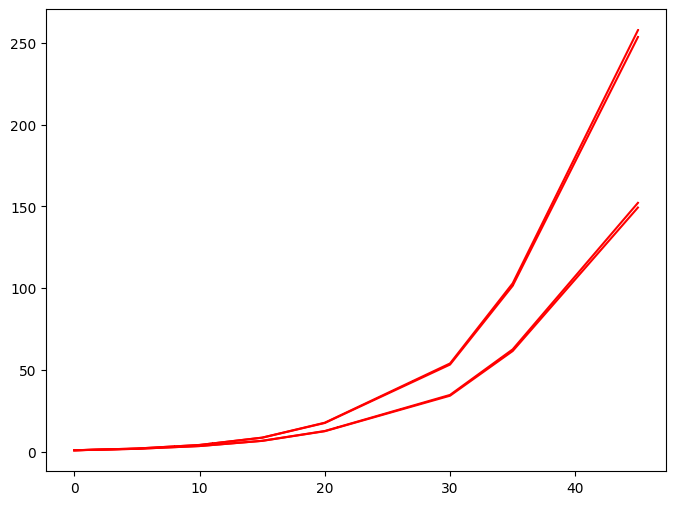

In [18]:
print(results.parameter_space.false_boxes[1].explain(  ))
results.plot(points=results.parameter_space.false_boxes[1].corner_points, variables=["I"], label_marker={"true":",", "false": ","})